In [1]:
from paretoKnapsackRestaurants import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}"
    })
else:
    mpl.rcParams.update({"text.usetex": False})

In [2]:
# function to sample numItems from the dataset
def sample_dataset(simMatrix, item_ids, item_costs, numItems, random_seed=None):
    '''
    Samples a subset of items from the dataset.
    Args:
        simMatrix (np.ndarray): Similarity matrix of shape (N, N).
        item_ids (list): List of item IDs of length N.
        item_costs (list): List of item costs of length N.
        numItems (int): Number of items to sample.
        random_seed (int | None): Optional seed for reproducibility.
    Returns:
        sampled_simMatrix (np.ndarray): Sampled similarity matrix of shape (numItems, numItems).
        sampled_item_ids (list): List of sampled item IDs of length numItems.
        sampled_item_costs (list): List of sampled item costs of length numItems.
    '''
    rng = np.random.default_rng(random_seed)
    sampled_indices = rng.choice(len(item_ids), size=numItems, replace=False)
    sampled_simMatrix = simMatrix[np.ix_(sampled_indices, sampled_indices)]
    sampled_item_ids = [item_ids[i] for i in sampled_indices]
    sampled_item_costs = [item_costs[i] for i in sampled_indices]

    return sampled_simMatrix, sampled_item_ids, sampled_item_costs

### Yelp - Single Sample Plotting

In [9]:
def findSingleSampleSolutions(simMatrix, item_ids, item_costs, sample_size, maxBudget, dataset_name=None, random_seed=None, plot_algos=None):
    '''
    Run algorithms for a single random sample and plot results (no averaging or interpolation).
    Args:
        simMatrix (np.ndarray): Similarity matrix of shape (N, N).
        item_ids (list): List of item IDs of length N.
        item_costs (list): List of item costs of length N.
        sample_size (int): Number of items to sample from the dataset.
        maxBudget (float): Maximum budget for the knapsack problem.
        dataset_name (str | None): Optional dataset name for output file naming.
        random_seed (int | None): Optional seed for reproducibility.
        plot_algos (dict | None): Optional dict of algorithm name -> bool to control plotting.
    '''
    # Cost grid (same for all budgets within this sample)
    num_steps, min_cost = 15, 1
    cost_arr = np.linspace(min_cost, maxBudget, num_steps)

    all_algo_names = ["PlainGreedy", "GreedyPlus-1Guess", "ParetoGreedy-Knapsack", "cov-epsgrid-greedy", "cost-epsgrid-greedy", "coverage-cost-grid-union-pareto", "TopK"]
    if plot_algos is None:
        plot_algos = {alg: True for alg in all_algo_names}
    algo_names = [alg for alg in all_algo_names if plot_algos.get(alg, False)]

    def sort_pairs(costs, objs):
        if len(costs) == 0:
            return np.array([]), np.array([])
        pairs = sorted(zip(costs, objs), key=lambda x: x[0])
        return np.array([p[0] for p in pairs], dtype=float), np.array([p[1] for p in pairs], dtype=float)

    def format_points(costs, objs):
        return [f"({c:.2f}, {v:.3f})" for c, v in zip(costs, objs)]

    # sample the dataset once
    sampled_simMatrix, sampled_item_ids, sampled_item_costs = sample_dataset(
        simMatrix, item_ids, item_costs, sample_size, random_seed=random_seed
    )

    # Pareto Greedy + Coverage Linear (computed once at full budget)
    paretoRest_full = paretoKnapsackRestaurants(n_items=sampled_item_ids,
                                                costs=sampled_item_costs,
                                                simMatrix=sampled_simMatrix,
                                                budget=maxBudget)
    pg1_costs, pg1_objectives, _, pg1_time = paretoRest_full.prefixParetoGreedy_1Guess()
    cl_costs, cl_objectives, _, cl_time = paretoRest_full.coverage_epsilon_grid()
    ce_costs, ce_objectives, _, ce_time = paretoRest_full.cost_epsilon_grid()
    union_costs, union_objectives = paretoRest_full.coverage_cost_grid_union_pareto(
        (ce_costs, ce_objectives), (cl_costs, cl_objectives)
    )

    # Per-budget results
    objectives = {alg: [] for alg in all_algo_names}
    runtimes = {alg: [] for alg in all_algo_names}

    for budgetVal in cost_arr:
        paretoRest = paretoKnapsackRestaurants(n_items=sampled_item_ids,
                                               costs=sampled_item_costs,
                                               simMatrix=sampled_simMatrix,
                                               budget=budgetVal)

        # Plain Greedy
        plain_items, curr_objective, curr_cost, runTime = paretoRest.plainGreedy()
        objectives['PlainGreedy'].append(curr_objective)
        runtimes['PlainGreedy'].append(runTime)

        # Two Guess Plain Greedy (disabled)
        # _, curr_objective, curr_cost, runTime = paretoRest.twoGuessPlainGreedy()
        # objectives['PlainGreedy-2Guess'].append(curr_objective)
        # runtimes['PlainGreedy-2Guess'].append(runTime)

        # One Guess Greedy Plus
        _, curr_objective, curr_cost, runTime = paretoRest.oneGuessGreedyPlus()
        objectives['GreedyPlus-1Guess'].append(curr_objective)
        runtimes['GreedyPlus-1Guess'].append(runTime)

        # Top-k (use #items chosen by PlainGreedy)
        k_val = max(1, len(plain_items))
        _, curr_objective, curr_cost, runTime = paretoRest.top_k(k_val)
        objectives['TopK'].append(curr_objective)
        runtimes['TopK'].append(runTime)

    runtimes['ParetoGreedy-Knapsack'].append(pg1_time)
    runtimes['cov-epsgrid-greedy'].append(cl_time)
    runtimes['cost-epsgrid-greedy'].append(ce_time)
    runtimes['coverage-cost-grid-union-pareto'].append(0.0)

    # Log pareto points per algorithm
    pg_costs_sorted, pg_objs_sorted = sort_pairs(pg1_costs, pg1_objectives)
    cl_costs_sorted, cl_objs_sorted = sort_pairs(cl_costs, cl_objectives)
    ce_costs_sorted, ce_objs_sorted = sort_pairs(ce_costs, ce_objectives)
    union_costs_sorted, union_objs_sorted = sort_pairs(union_costs, union_objectives)
    logging.info("Pareto points - ParetoGreedy-Knapsack: %s", format_points(pg_costs_sorted, pg_objs_sorted))
    logging.info("Pareto points - cov-epsgrid-greedy: %s", format_points(cl_costs_sorted, cl_objs_sorted))
    logging.info("Pareto points - cost-epsgrid-greedy: %s", format_points(ce_costs_sorted, ce_objs_sorted))
    logging.info("Pareto points - coverage-cost-grid-union-pareto: %s", format_points(union_costs_sorted, union_objs_sorted))
    logging.info("Pareto points - PlainGreedy: %s", format_points(cost_arr, objectives['PlainGreedy']))
    # logging.info("Pareto points - PlainGreedy-2Guess: %s", format_points(cost_arr, objectives['PlainGreedy-2Guess']))
    logging.info("Pareto points - GreedyPlus-1Guess: %s", format_points(cost_arr, objectives['GreedyPlus-1Guess']))
    logging.info("Pareto points - TopK: %s", format_points(cost_arr, objectives['TopK']))

    # Plot
    colors = plt.get_cmap("tab10").colors
    marker_map = {
        "ParetoGreedy-Knapsack": "D",
        "cov-epsgrid-greedy": "o",
        "cost-epsgrid-greedy": "X",
        "coverage-cost-grid-union-pareto": "^",
        "PlainGreedy": "s",
        "GreedyPlus-1Guess": "v",
        "TopK": "P"
    }
    marker_sizes = {"ParetoGreedy-Knapsack": 6, "cov-epsgrid-greedy": 7, "cost-epsgrid-greedy": 7, "coverage-cost-grid-union-pareto": 7, "PlainGreedy": 6, "GreedyPlus-1Guess": 6, "TopK": 6}
    linestyle_map = {"ParetoGreedy-Knapsack": '-', "cov-epsgrid-greedy": '-', "cost-epsgrid-greedy": '-', "coverage-cost-grid-union-pareto": '-', "PlainGreedy": ':', "GreedyPlus-1Guess": '-.', "TopK": ':'}
    zorder_map = {"ParetoGreedy-Knapsack": 8, "cov-epsgrid-greedy": 7, "cost-epsgrid-greedy": 6, "coverage-cost-grid-union-pareto": 5, "TopK": 4, "GreedyPlus-1Guess": 3, "PlainGreedy": 1}
    alpha_map = {"ParetoGreedy-Knapsack": 0.9, "cov-epsgrid-greedy": 0.95, "cost-epsgrid-greedy": 0.95, "coverage-cost-grid-union-pareto": 0.95, "TopK": 0.9, "GreedyPlus-1Guess": 0.9, "PlainGreedy": 0.9}
    mfc_map = {"ParetoGreedy-Knapsack": None, "cov-epsgrid-greedy": "white", "cost-epsgrid-greedy": "white", "coverage-cost-grid-union-pareto": "white", "TopK": "white", "GreedyPlus-1Guess": None, "PlainGreedy": None}

    series_map = {
        "ParetoGreedy-Knapsack": sort_pairs(pg1_costs, pg1_objectives),
        "cov-epsgrid-greedy": sort_pairs(cl_costs, cl_objectives),
        "cost-epsgrid-greedy": sort_pairs(ce_costs, ce_objectives),
        "coverage-cost-grid-union-pareto": sort_pairs(union_costs, union_objectives),
        "PlainGreedy": (cost_arr, np.array(objectives['PlainGreedy'], dtype=float)),
        "GreedyPlus-1Guess": (cost_arr, np.array(objectives['GreedyPlus-1Guess'], dtype=float)),
        "TopK": (cost_arr, np.array(objectives['TopK'], dtype=float))
    }

    fig, ax = plt.subplots(figsize=(9, 5.5))
    for i, alg in enumerate(algo_names):
        color = colors[i % len(colors)]
        marker = marker_map.get(alg, 'o')
        x_vals, y_vals = series_map[alg]
        label_text = alg.replace('_', r'\_')
        ax.plot(x_vals, y_vals,
                label=rf"\texttt{{{label_text}}}",
                color=color,
                linestyle=linestyle_map.get(alg, ':'),
                marker=marker,
                markersize=marker_sizes.get(alg, 6),
                markeredgewidth=1.2,
                markeredgecolor='k',
                markerfacecolor=(mfc_map.get(alg) if mfc_map.get(alg) is not None else color),
                linewidth=1.8,
                alpha=alpha_map.get(alg, 0.9),
                zorder=zorder_map.get(alg, 1))

    ax.set_xlabel(r'Cost ($c_\ell$)', fontsize=28)
    ax.set_ylabel(r'Objective value ($f$)', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)
    ax.legend(fontsize=18)

    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "knapsack" / "single_sample"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_knapsack_single_sample.pdf"
    fig.savefig(out_path, bbox_inches="tight")

    plt.show()

    # Runtime summary (seconds)
    runtime_lines = ["Runtime summary (seconds):"]
    for alg in algo_names:
        total_runtime = float(np.nansum(np.array(runtimes.get(alg, []), dtype=float)))
        runtime_lines.append(f"  - {alg}: {total_runtime:.3f}")
    print("\n".join(runtime_lines))

### Yelp Phoenix Single Sample

In [10]:
# Import Yelp dataset
data_path = '../../datasets/pickled_data/yelp/yelp_phoenix_'

# Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    phoenix_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    phoenix_simMatrix = pickle.load(fp)

with open(data_path + 'costs.pkl', "rb") as fp:
    phoenix_costs = pickle.load(fp)

2026-02-02 23:05:53,482 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:15, Budget=250
2026-02-02 23:05:53,563 |INFO: CoverageLinear epsilon grid: eps=0.100, min_obj=1.238, max_obj=15.000, points=28
2026-02-02 23:05:53,593 |INFO: Cost epsilon grid: eps=0.100, min_cost=0.460, max_budget=250.000, points=68
2026-02-02 23:05:57,273 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:15, Budget=1.0
2026-02-02 23:05:57,274 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:15, Budget=18.785714285714285
2026-02-02 23:05:57,285 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:15, Budget=36.57142857142857
2026-02-02 23:05:57,326 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:15, Budget=54.357142857142854
2026-02-02 23:05:57,397 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:15, Budget=72.14285714285714
2026-02-02 23:05:57,496 |INFO: Initialized Pareto R

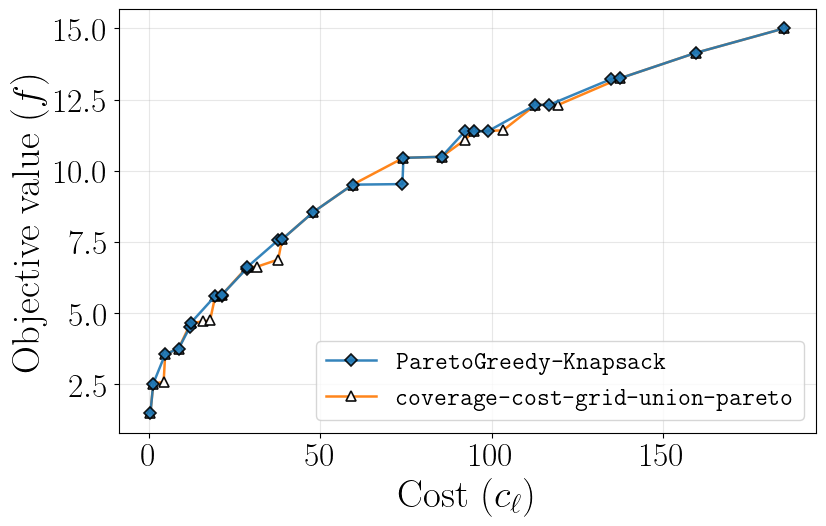

Runtime summary (seconds):
  - ParetoGreedy-Knapsack: 0.079
  - coverage-cost-grid-union-pareto: 0.000


In [15]:
# Call findSingleSampleSolutions (adjust parameters as needed)
sample_size = 15
maxBudget = 250
random_seed = 42

plot_algos = {
    "ParetoGreedy-Knapsack": True,
    "cov-epsgrid-greedy": False,
    "cost-epsgrid-greedy": False,
    "coverage-cost-grid-union-pareto": True,
    "PlainGreedy": False,
    "GreedyPlus-1Guess": False,
    "TopK": False
}

findSingleSampleSolutions(
    phoenix_simMatrix, phoenix_ids, phoenix_costs,
    sample_size, maxBudget,
    dataset_name="Yelp-PHX",
    random_seed=random_seed,
    plot_algos=plot_algos
 )

### Yelp Vegas Single Sample

In [6]:
# Import Vegas dataset
data_path = '../../datasets/pickled_data/yelp/yelp_vegas_' 

# Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    vegas_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    vegas_simMatrix = pickle.load(fp)

with open(data_path + 'costs.pkl', "rb") as fp:
    vegas_costs = pickle.load(fp)

2026-02-02 23:04:23,788 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:20, Budget=200
2026-02-02 23:04:23,965 |INFO: CoverageLinear epsilon grid: eps=0.100, min_obj=1.336, max_obj=20.000, points=30
2026-02-02 23:04:24,025 |INFO: Cost epsilon grid: eps=0.100, min_cost=2.886, max_budget=200.000, points=46
2026-02-02 23:04:39,864 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:20, Budget=1.0
2026-02-02 23:04:39,865 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:20, Budget=15.214285714285714
2026-02-02 23:04:39,883 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:20, Budget=29.428571428571427
2026-02-02 23:04:39,965 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:20, Budget=43.64285714285714
2026-02-02 23:04:40,114 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:20, Budget=57.857142857142854
2026-02-02 23:04:40,355 |INFO: Initialized Pareto 

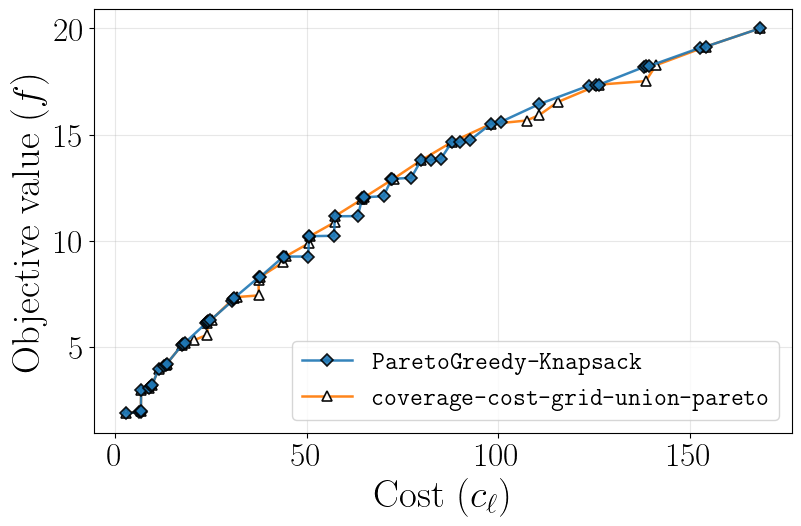

Runtime summary (seconds):
  - ParetoGreedy-Knapsack: 0.175
  - coverage-cost-grid-union-pareto: 0.000


In [13]:
# Call findSingleSampleSolutions (adjust parameters as needed)
sample_size = 20
maxBudget = 200
random_seed = 42

# plot_algos = {
#     "ParetoGreedy-Knapsack": False,
#     "cov-epsgrid-greedy": True,
#     "cost-epsgrid-greedy": True,
#     "coverage-cost-grid-union-pareto": True,
#     "PlainGreedy": True,
#     "GreedyPlus-1Guess": False,
#     "TopK": False
# }

findSingleSampleSolutions(
    vegas_simMatrix, vegas_ids, vegas_costs,
    sample_size, maxBudget,
    dataset_name="Yelp-LV",
    random_seed=random_seed,
    plot_algos=plot_algos
 )